In [60]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import torch

warnings.filterwarnings("ignore")

In [61]:
# To do

# eda on time_diff variable, buckets of points to grab log odds of out from the 0 and 1s
# look at what we know, t and d, check how calibration looks on those, then add behind, then interactions, 
# then possiby t-d which was similary to what we were doing before with the wrong calculation

In [62]:
df = pd.read_csv('new_rays_fly_outs_jump.csv')
df

,t,x,y,d,behind,out
0,2.614024,-90.718545,270.202847,44.472007,0,0
1,3.991177,196.421572,233.262709,69.184066,1,0
2,5.621253,109.370850,245.581613,29.137958,0,1
3,5.793945,102.455643,192.532069,76.040305,0,1
4,3.868917,-149.174802,249.064195,21.160832,0,1
...,...,...,...,...,...,...
15454,5.068174,129.130582,321.775307,59.972506,1,1
15455,6.554159,-55.573587,231.123549,86.057228,0,1
15456,2.861253,138.313465,213.373971,48.826851,0,0
15457,5.815816,-16.381330,50.674002,19.102309,0,1


In [63]:
# eda calibration

def eda_calibration(preds, actuals, groupsize = 1000, use_log_odds = True, title = '', xlab = '', ylab = ''):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    if use_log_odds:
        actual = np.array(actual)
        plt.plot(predicted, np.log(actual / (1-actual)), 'k.')
    else:
        plt.plot(predicted, actual, 'k.')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

# calibration function

def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)
    plt.show()

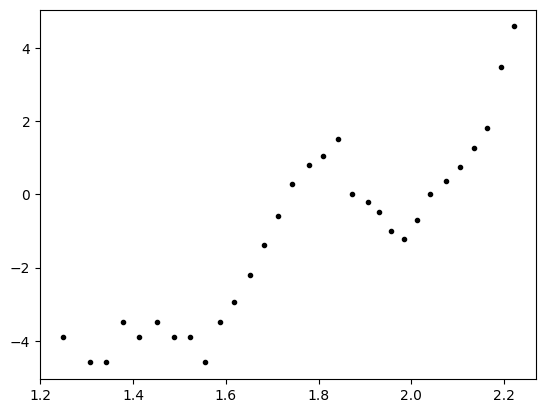

In [64]:
df['time_diff'] = df.t.values - df.d.values / 29

eda_calibration(df.time_diff.values, df.out.values, 100)
plt.show()

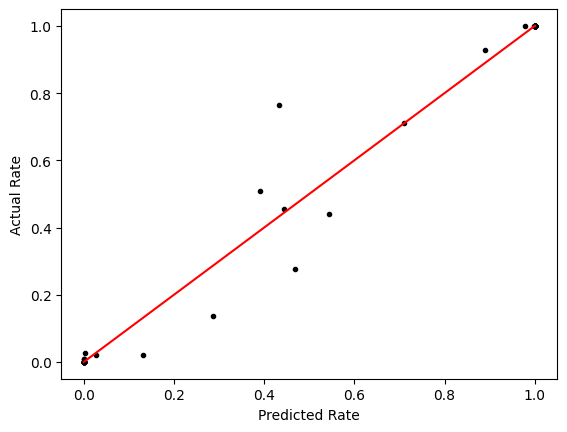

In [65]:
# time difference

df['time_diff2'] = df.time_diff.values**2
df['time_diff3'] = df.time_diff.values**3
df['time_diff4'] = df.time_diff.values**4
features1 = ['time_diff', 'time_diff2', 'time_diff3']

mod = LogisticRegression(penalty = 'none').fit(df[features1].values, df.out.values)
preds = mod.predict_proba(df[features1].values)

calibration(preds[:,1], df.out.values, 250)

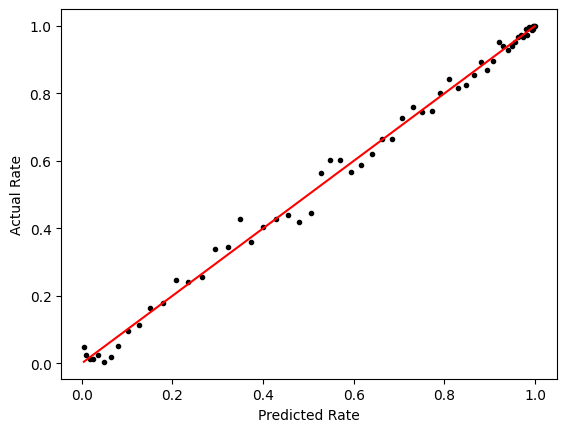

In [66]:
# hang time

df['t2'] = df.t.values**2
df['t3'] = df.t.values**3
features2 = ['t', 't2', 't3']

mod2 = LogisticRegression(penalty = 'none').fit(df[features2].values, df.out.values)
preds = mod2.predict_proba(df[features2].values)

calibration(preds[:,1], df.out.values, 250)

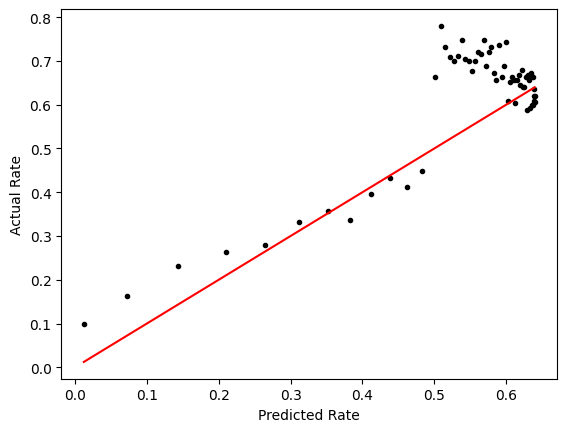

In [67]:
# distance

df['d2'] = df.d.values**2
df['d3'] = df.d.values**3
features3 = ['d', 'd2', 'd3']

mod3 = LogisticRegression(penalty = 'none').fit(df[features3].values, df.out.values)
preds = mod3.predict_proba(df[features3].values)

calibration(preds[:,1], df.out.values, 250)

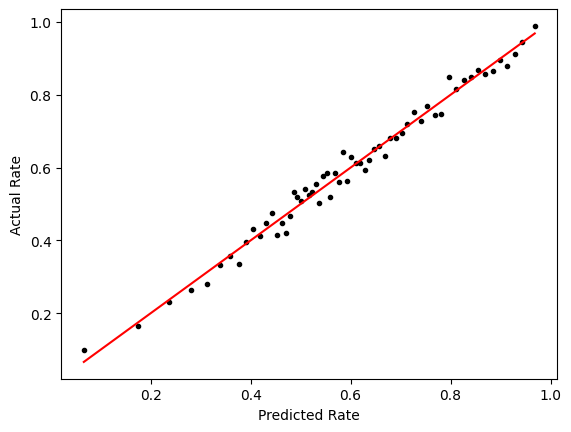

In [68]:
# distance time

df['d_time'] = df.d.values / 29

df['d_time2'] = df.d_time.values**2
df['d_time3'] = df.d_time.values**3
features3 = ['d_time', 'd_time2', 'd_time3']

mod3 = LogisticRegression(penalty = 'none').fit(df[features3].values, df.out.values)
preds = mod3.predict_proba(df[features3].values)

calibration(preds[:,1], df.out.values, 250)

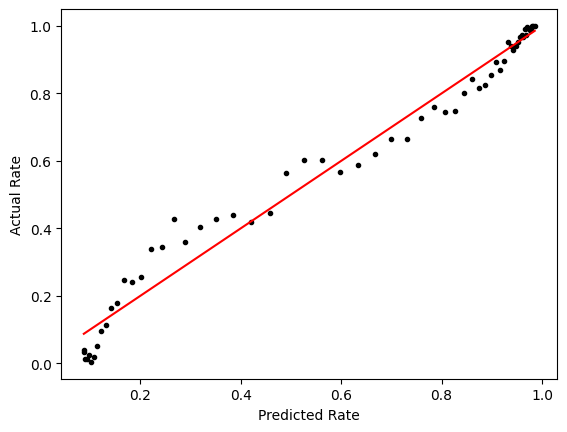

In [69]:
# time distance

df['t_distance'] = df.t.values * 29

df['t_distance2'] = df.t_distance.values**2
df['t_distance3'] = df.t_distance.values**3
features3 = ['t_distance', 't_distance2', 't_distance3']

mod3 = LogisticRegression(penalty = 'none').fit(df[features3].values, df.out.values)
preds = mod3.predict_proba(df[features3].values)

calibration(preds[:,1], df.out.values, 250)

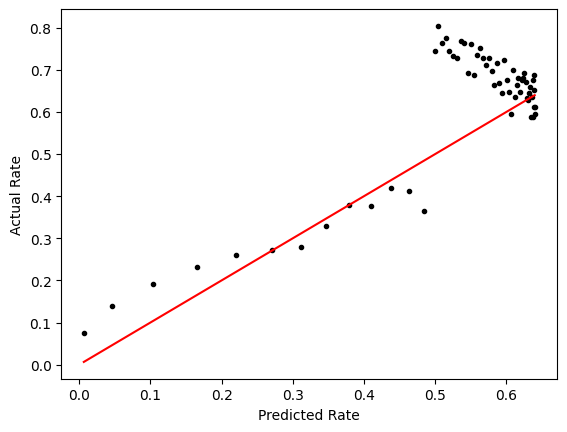

In [70]:
# Time - Distance

df['t_d_diff'] = df.t.values - df.d.values

df['t_d_diff2'] = df.t_d_diff.values**2
df['t_d_diff3'] = df.t_d_diff.values**3
features4 = ['t_d_diff', 't_d_diff2', 't_d_diff3']

mod4 = LogisticRegression(penalty = 'none').fit(df[features4].values, df.out.values)
preds = mod4.predict_proba(df[features4].values)

calibration(preds[:,1], df.out.values, 250)

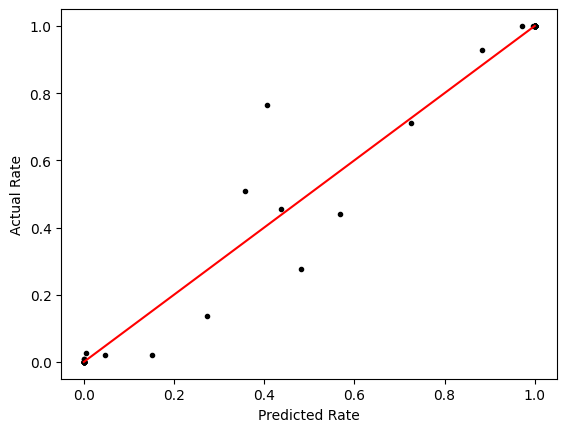

In [71]:
# t_distance - distance

df['t_distance_d_diff'] = df.t_distance.values - df.d.values

df['t_distance_d_diff2'] = df.t_distance_d_diff.values**2
df['t_distance_d_diff3'] = df.t_distance_d_diff.values**3
features4 = ['t_distance_d_diff', 't_distance_d_diff2', 't_distance_d_diff3']

mod4 = LogisticRegression(penalty = 'none').fit(df[features4].values, df.out.values)
preds = mod4.predict_proba(df[features4].values)

calibration(preds[:,1], df.out.values, 250)

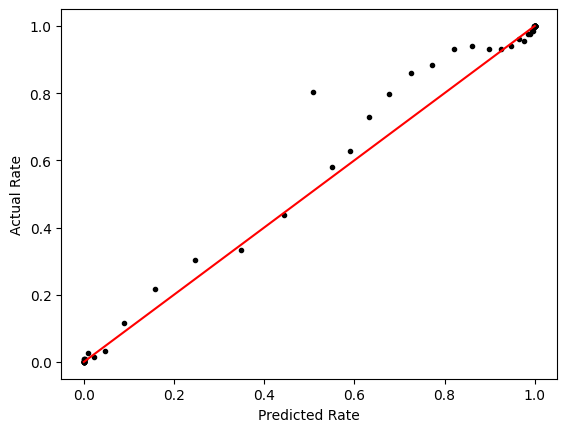

In [72]:
# hang time, distance, time_distance_inter

df['t_d_inter'] = df.t.values * df.d.values
df['t_d_inter2'] = df.t2.values * df.d2.values
df['t_d_inter3'] = df.t3.values * df.d3.values
features5 = ['t', 't2', 't3', 'd', 'd2', 'd3', 't_d_inter', 't_d_inter2', 't_d_inter3']

mod5 = LogisticRegression().fit(df[features5].values, df.out.values)
preds = mod5.predict_proba(df[features5].values)

calibration(preds[:,1], df.out.values, 250)

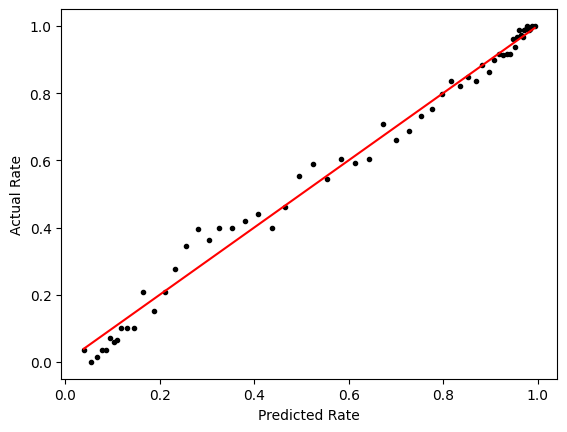

In [73]:
# behind, hang time, behind_time_inter

df['behind_time_inter'] = df.behind.values * df.t.values
df['behind_time_inter2'] = df.behind.values * df.t2.values
df['behind_time_inter3'] = df.behind.values * df.t3.values
features5 = ['behind', 't', 't2', 't3', 'behind_time_inter', 'behind_time_inter2', 'behind_time_inter3']

mod5 = LogisticRegression().fit(df[features5].values, df.out.values)
preds = mod5.predict_proba(df[features5].values)

calibration(preds[:,1], df.out.values, 250)

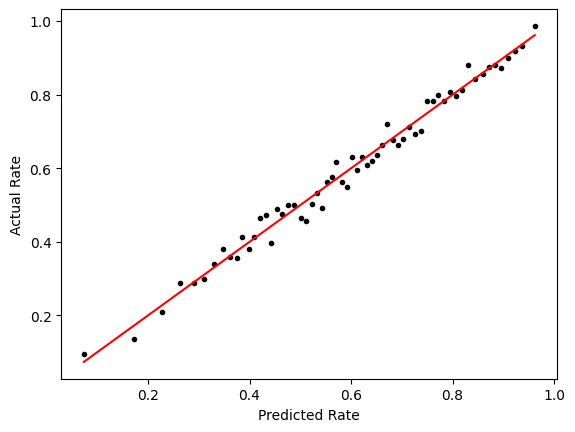

In [74]:
# behind, distance time, behind_time_inter

df['behind_dtime_inter'] = df.behind.values * df.d_time.values
df['behind_dtime_inter2'] = df.behind.values * df.d_time2.values
df['behind_dtime_inter3'] = df.behind.values * df.d_time3.values
features6 = ['behind', 'd_time', 'd_time2', 'd_time3', 'behind_dtime_inter', 'behind_dtime_inter2', 'behind_dtime_inter3']

mod6 = LogisticRegression().fit(df[features6].values, df.out.values)
preds = mod6.predict_proba(df[features6].values)

calibration(preds[:,1], df.out.values, 250)

# Coefficents

In [77]:
train, test = train_test_split(df, test_size = 0.3)

,t,x,y,d,behind,out,time_diff,time_diff2,time_diff3,time_diff4,...,t_distance_d_diff3,t_d_inter,t_d_inter2,t_d_inter3,behind_time_inter,behind_time_inter2,behind_time_inter3,behind_dtime_inter,behind_dtime_inter2,behind_dtime_inter3
0,2.614024,-90.718545,270.202847,44.472007,0,0,1.080506,1.167494,1.261485,1.363043,...,3.076636e+04,116.250891,13514.269755,1.571046e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.991177,196.421572,233.262709,69.184066,1,0,1.605519,2.577692,4.138534,6.644495,...,1.009347e+05,276.125828,76245.472941,2.105334e+07,3.991177,15.929491,63.577412,2.385657,5.691361,13.577639
2,5.621253,109.370850,245.581613,29.137958,0,1,4.616496,21.312038,98.386946,454.202974,...,2.399559e+06,163.791849,26827.769697,4.394170e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.793945,102.455643,192.532069,76.040305,0,1,3.171866,10.060733,31.911297,101.218354,...,7.782846e+05,440.573374,194104.898078,8.551745e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.868917,-149.174802,249.064195,21.160832,0,1,3.139233,9.854785,30.936469,97.116791,...,7.545095e+05,81.869506,6702.616002,5.487399e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15454,5.068174,129.130582,321.775307,59.972506,1,1,3.000157,9.000942,27.004238,81.016951,...,6.586064e+05,303.951120,92386.283634,2.808091e+07,5.068174,25.686392,130.183113,2.068017,4.276696,8.844282
15455,6.554159,-55.573587,231.123549,86.057228,0,1,3.586668,12.864190,46.139582,165.487376,...,1.125298e+06,564.032750,318132.942999,1.794374e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15456,2.861253,138.313465,213.373971,48.826851,0,0,1.177569,1.386668,1.632897,1.922848,...,3.982471e+04,139.705979,19517.760572,2.726748e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15457,5.815816,-16.381330,50.674002,19.102309,0,1,5.157115,26.595840,137.157815,707.338683,...,3.345142e+06,111.095508,12342.211999,1.371164e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


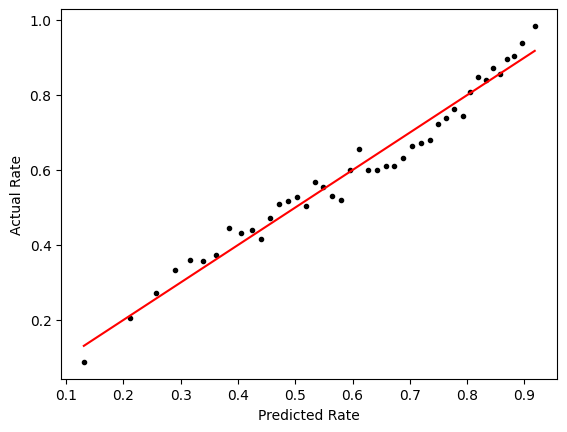

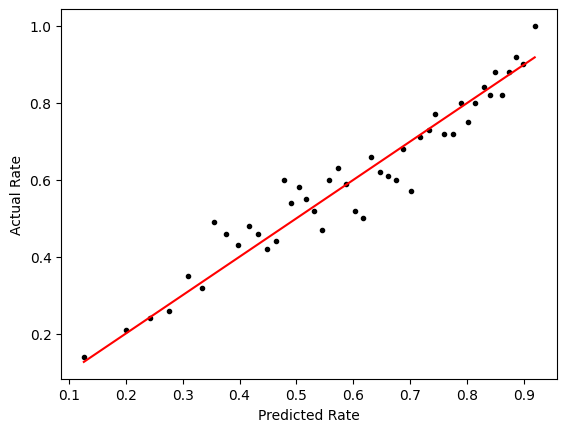

(array([[-1.13185202]]), array([2.77243445]))

In [80]:
features1 = ['d_time']
mod = LogisticRegression().fit(train[features1].values, train.out.values)
tpre = mod.predict_proba(train[features1].values)
tepre = mod.predict_proba(test[features1].values)
calibration(tpre[:,1], train.out.values, 250)
plt.show()
calibration(tepre[:,1], test.out.values, 100)
plt.show()

mod.coef_, mod.intercept_

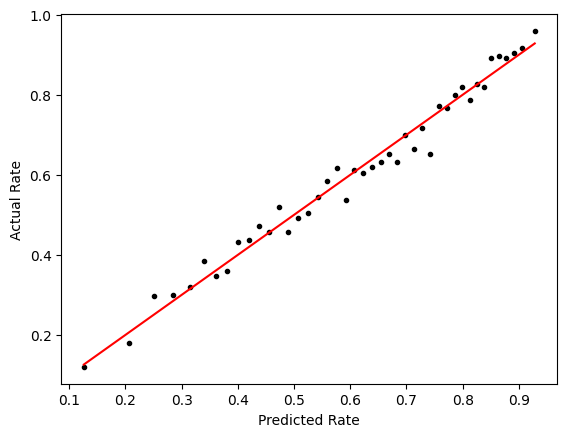

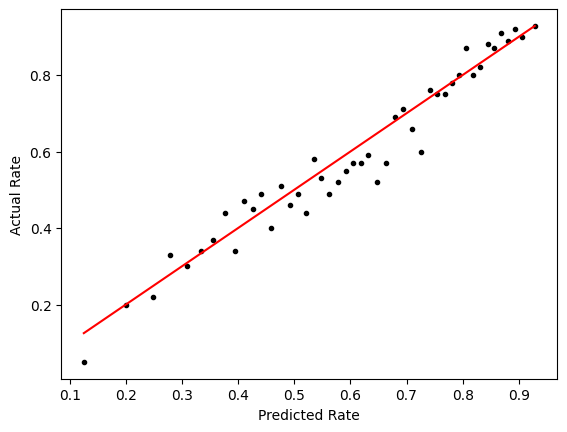

(array([[-1.14009353,  0.59609073]]), array([2.46743505]))

In [ ]:
features2 = ['d_time', 'behind']
mod = LogisticRegression().fit(train[features2].values, train.out.values)
tpre = mod.predict_proba(train[features2].values)
tepre = mod.predict_proba(test[features2].values)
calibration(tpre[:,1], train.out.values, 250)
plt.show()
calibration(tepre[:,1], test.out.values, 100)
plt.show()
mod.coef_, mod.intercept_

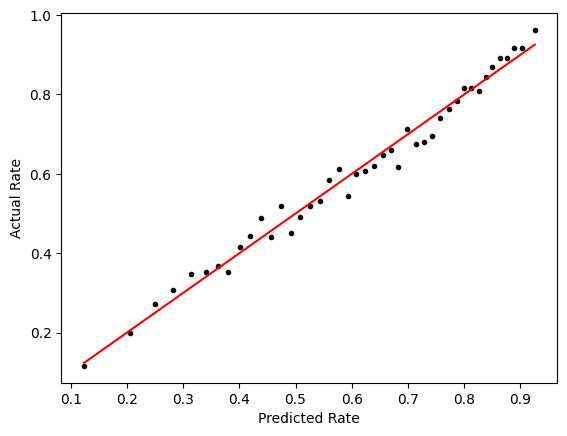

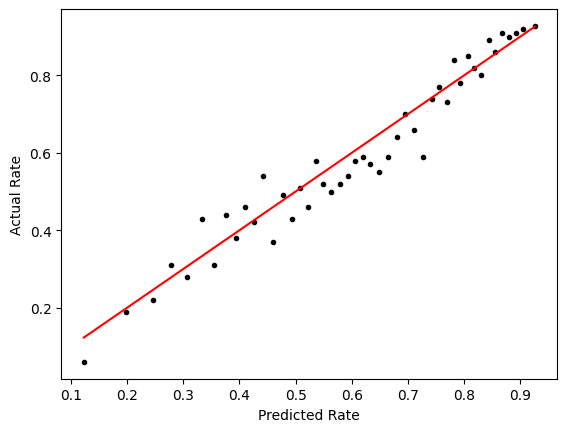

(array([[-1.17479449,  0.46957271,  0.05978375]]), array([2.53757144]))

In [ ]:
features = ['d_time', 'behind', 'behind_dtime_inter']
mod = LogisticRegression().fit(train[features].values, train.out.values)
tpre = mod.predict_proba(train[features].values)
tepre = mod.predict_proba(test[features].values)
calibration(tpre[:,1], train.out.values, 250)
plt.show()
calibration(tepre[:,1], test.out.values, 100)
plt.show()
mod.coef_, mod.intercept_

# Marginal Effects

In [ ]:
features = ['d_time', 'behind', 'behind_dtime_inter']
mod = LogisticRegression().fit(df[features].values, df.out.values)

mod.intercept_, mod.coef_

(array([2.57520883]), array([[-1.19792125,  0.40910826,  0.08230855]]))

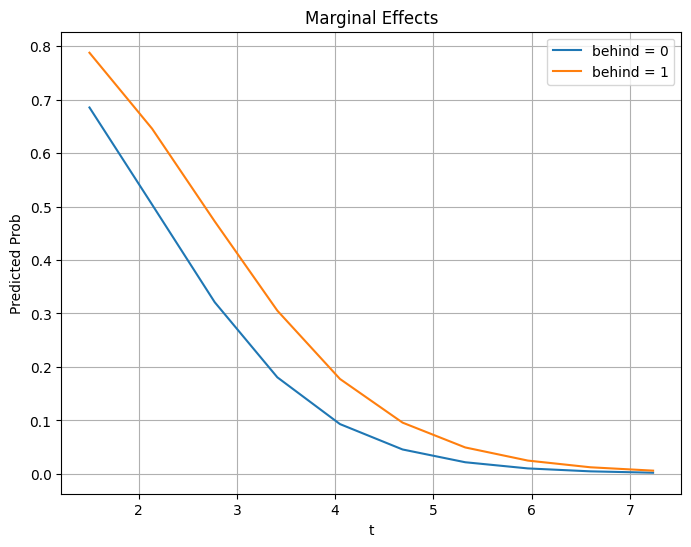

In [ ]:
# marginal effects of t

t_values = np.linspace(df['t'].min(), df['t'].max(), 10)
behind_values = df['behind'].unique()

marginal_effects = []

for t in t_values:
    for b in behind_values:
        interaction_value = t * b
        X_new = np.array([[t, b, interaction_value]])
        marginal_effect = mod.predict_proba(X_new)[:, 1]  # Probability of class 1
        marginal_effects.append({'t': t, 'behind': b, 'marginal_effect': marginal_effect[0]})

fig, ax = plt.subplots(figsize=(8, 6))

for b in behind_values:
    effects = [m for m in marginal_effects if m['behind'] == b]
    plt.plot([m['t'] for m in effects], [m['marginal_effect'] for m in effects], label=f'behind = {b}')

plt.xlabel('t')
plt.ylabel('Predicted Prob')
plt.title('Marginal Effects')
plt.legend()
plt.grid()
plt.show()

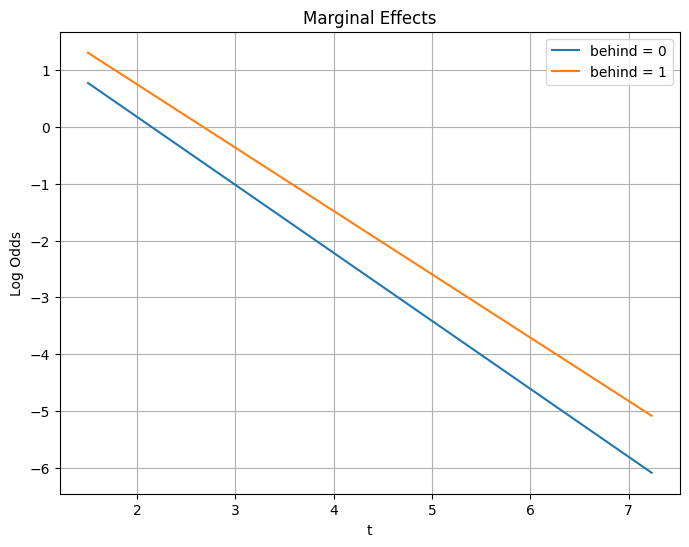

In [ ]:
# log odds

marginal_effects = []

for t in t_values:
    for b in behind_values:
        interaction_value = t * b
        X_new = np.array([[t, b, interaction_value]])
        marginal_effect = np.log(mod.predict_proba(X_new)[:, 1] / (1 - mod.predict_proba(X_new)[:, 1]))  # Log odds
        marginal_effects.append({'t': t, 'behind': b, 'marginal_effect': marginal_effect[0]})

fig, ax = plt.subplots(figsize=(8, 6))

for b in behind_values:
    effects = [m for m in marginal_effects if m['behind'] == b]
    plt.plot([m['t'] for m in effects], [m['marginal_effect'] for m in effects], label=f'behind = {b}')

plt.xlabel('t')
plt.ylabel('Log Odds')
plt.title('Marginal Effects')
plt.legend()
plt.grid()
plt.show()

In [ ]:
fb_intercept = 2.57520883
fb_d_time = -1.19792125
fb_is_backward = 0.40910826
fb_inter = 0.08230855
logodds = fb_intercept + test.d_time.values * fb_d_time + test.behind.values * fb_is_backward + test.behind_dtime_inter.values * fb_inter
probits = torch.special.expit(torch.tensor(logodds, dtype = torch.float32)).numpy()

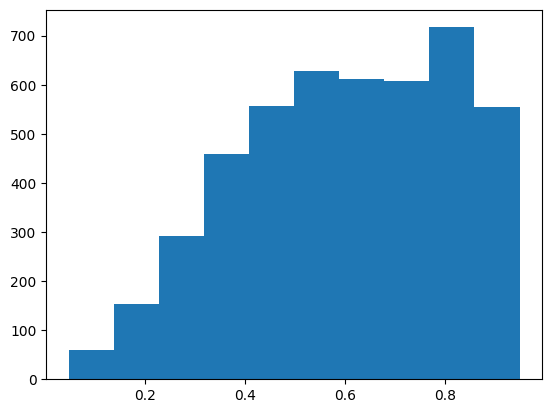

In [ ]:
plt.hist(probits)
plt.show()

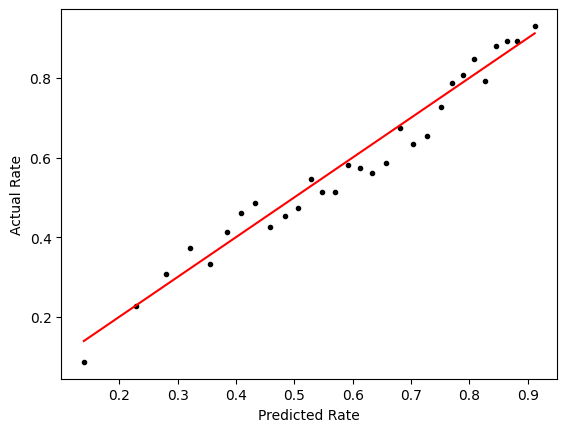

In [ ]:
calibration(probits, test.out.values, 150)
plt.show()